# Task

### Pre-defined code

In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

# Downloading all the required libraries


# Importing all the required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import style
from glob import glob
from natsort import natsorted
from tqdm import tqdm
style.use('ggplot')

Mounted at /content/drive


In [ ]:
# Loading all the images in the drive
gt_images = []

for files in tqdm(natsorted(glob('/content/drive/My Drive/ES666CV/images/B/*'))):
    gt_images.append(cv2.imread(files, 1))

gt_images = np.array(gt_images) # Only possible because all images are of same size

100%|██████████| 6/6 [00:02<00:00,  2.57it/s]


In [ ]:
def show_image_grid(images, M, N, title='Title', figsize=8):
    # Assuming 'images' is a numpy array of shape (num_images, height, width, channels)
    if M==1:
        row_size = figsize
        col_size = figsize//4
    elif N==1:
        row_size = figsize//4
        col_size = figsize
    else:
        row_size, col_size = figsize, figsize

    fig, axes = plt.subplots(M, N, figsize=(row_size, col_size))

    if len(images.shape) < 4:
        images = np.expand_dims(images.copy(), axis=0)

    fig.suptitle(title)
    for i in range(M):
        for j in range(N):
            if M==1 and N==1:
                ax = axes
            elif M == 1 or N==1:
                ax = axes[max(i, j)]
            else:
                ax = axes[i, j]
            index = i * N + j
            if index < images.shape[0]:
                ax.imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))
            ax.axis('off')
    plt.tight_layout()
    plt.show()

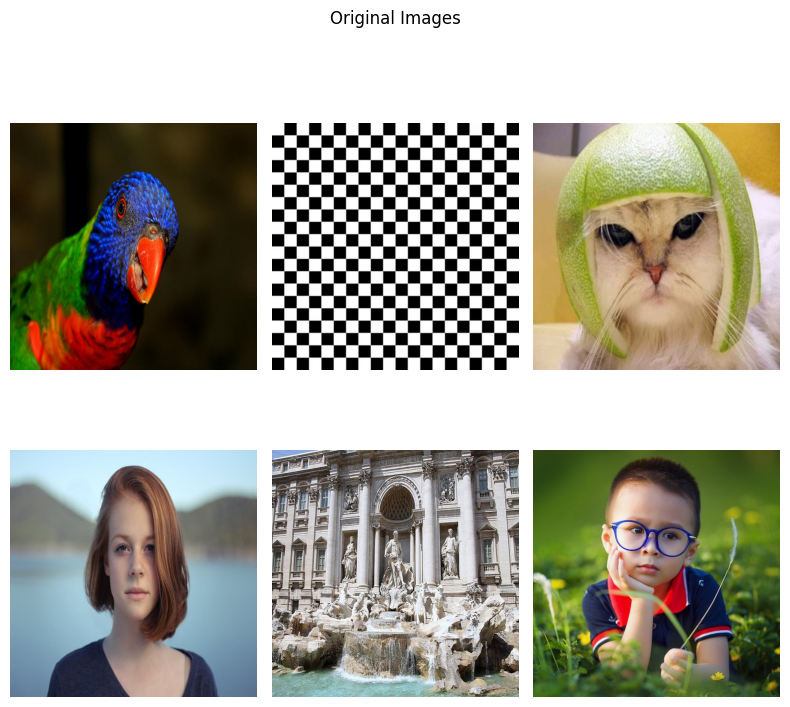

In [ ]:
show_image_grid(gt_images, 2, 3, 'Original Images', figsize=8)

### Q1 [2 Marks]

Implement Gaussian Pyramid Downsampling method from scratch.Compare it with Opencv resize method. What difference do you observe when you resize an image with Gaussian Pyramid approach and Opencv approach.

References:
1. [Gaussian & Laplacian pyramid	construction](https://www.cs.toronto.edu/~mangas/teaching/320/slides/CSC320L10.pdf)
2. [Multi-Scale Representation](https://medium.com/jun94-devpblog/cv-4-multi-scale-representation-gaussian-and-laplacian-pyramid-527ca4c4831c)

In [ ]:
def pad_image_to_divisible(image, K, pad_value=0):
    # Get the original image dimensions
    h, w = image.shape[:2]

    # Calculate the padding needed for height and width
    pad_h = (K - (h % K)) % K  # Padding needed for height
    pad_w = (K - (w % K)) % K  # Padding needed for width

    # Compute the padding to add to top/bottom and left/right
    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left

    # Pad the image: (top, bottom), (left, right), and (no padding on channels)
    if len(image.shape) == 3:  # For RGB images
        padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)),
                              mode='constant', constant_values=pad_value)
    else:  # For grayscale images
        padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right)),
                              mode='constant', constant_values=pad_value)

    return padded_image

In [ ]:
def gaussian_pyramid(image, levels):
    pyramid = [image]
    for i in range(levels - 1):
        # Apply Gaussian blur and downsample by a factor of 2

        # Apply Gaussian blur to smooth the image and prevent aliasing
        smoothed_image = cv2.GaussianBlur(pyramid[i], (5, 5), 0)

        #Downsample by 2 (by taking every other pixel)
        image = smoothed_image[::2,::2]

        image = pad_image_to_divisible(image, pyramid[0].shape[0])
        pyramid.append(image)

    return np.array(pyramid)

def opencv_resize(inp_image, levels):
    pyramid = []
    h, w    = inp_image.shape[:2]
    for i in range(levels):
        image = cv2.resize(inp_image, (h//(2**i), w//(2**i)))

        image = pad_image_to_divisible(image, min(h, w))
        pyramid.append(image)

    return np.array(pyramid)

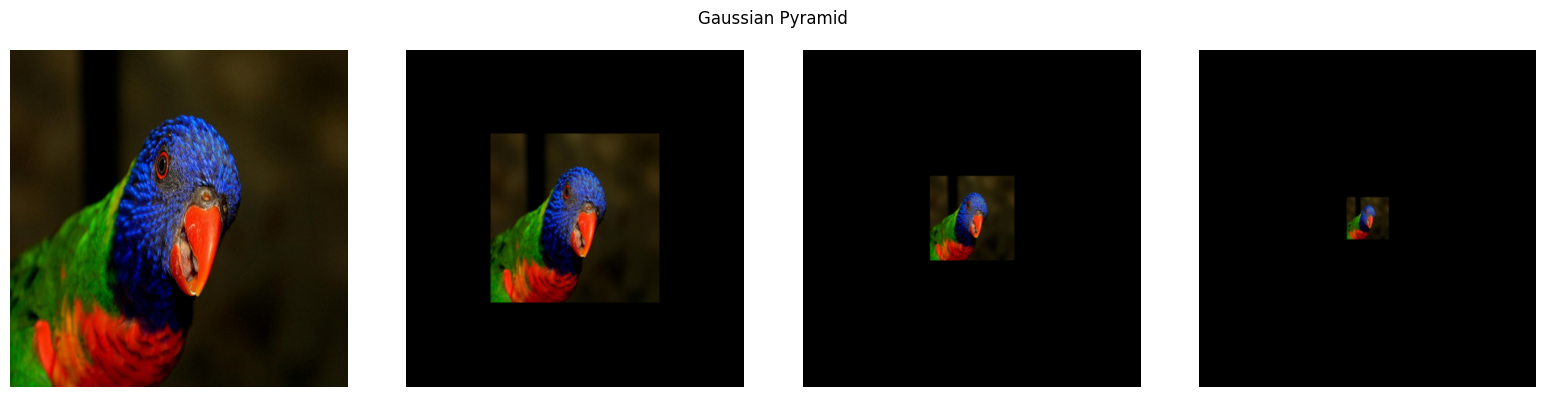

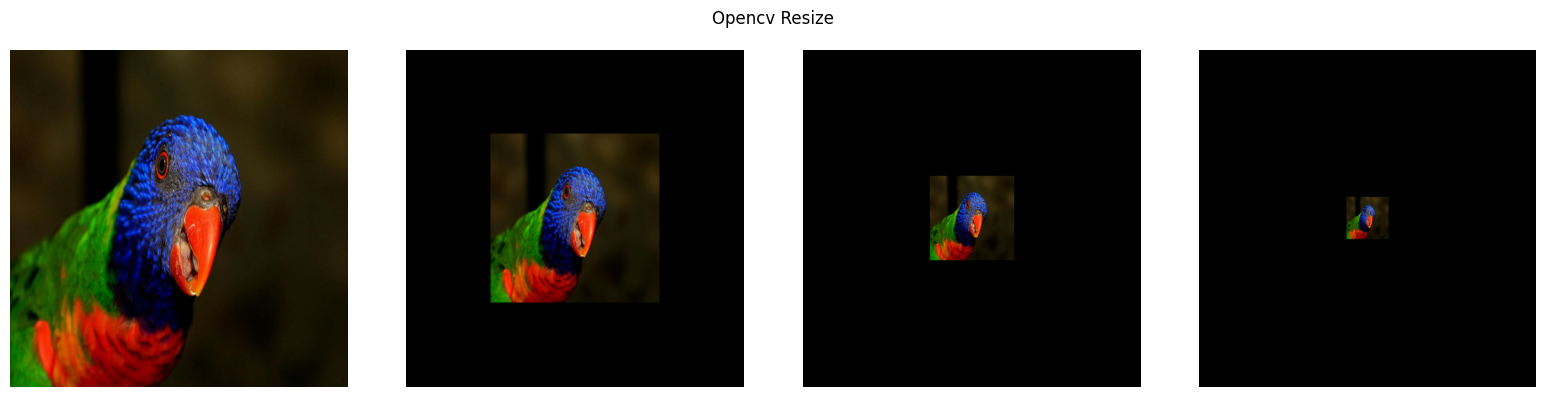

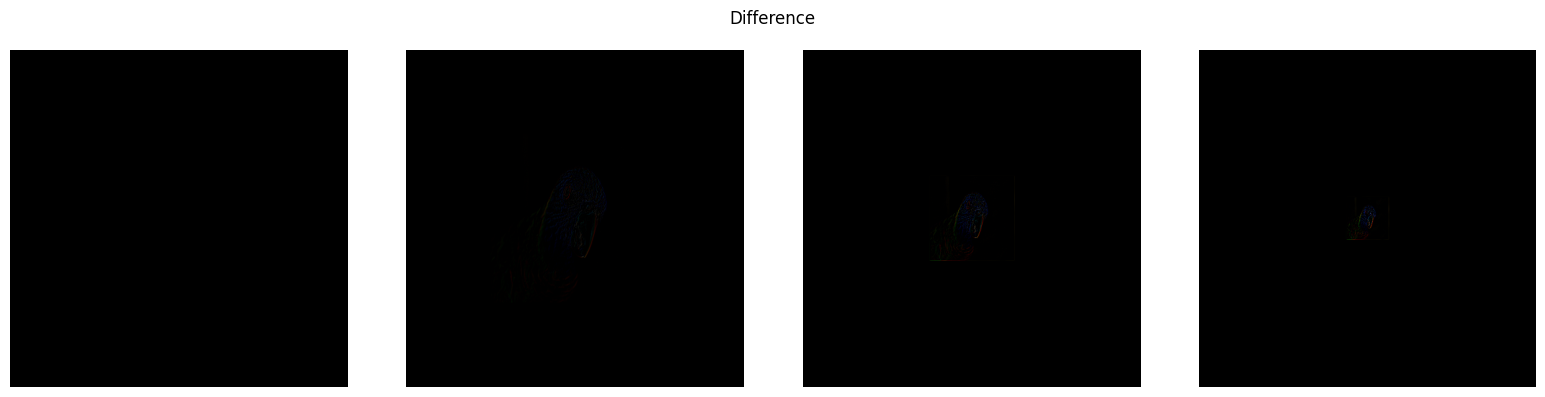

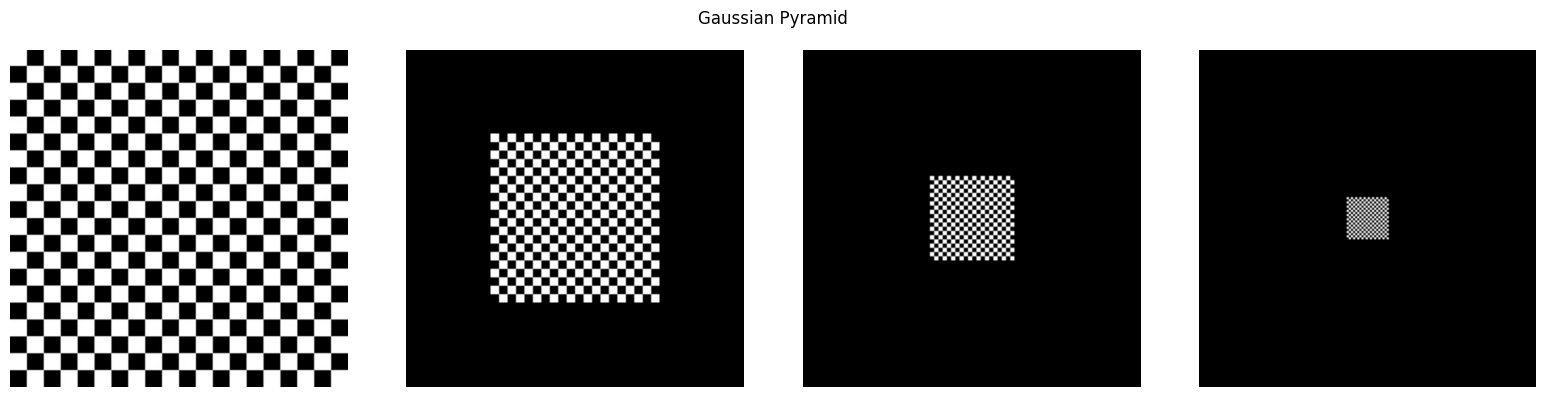

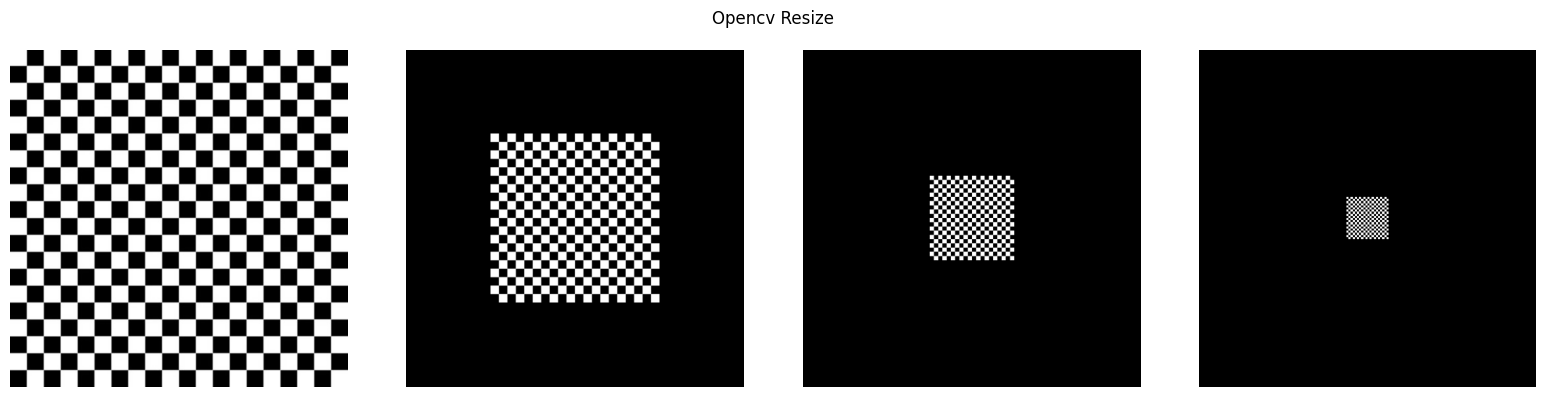

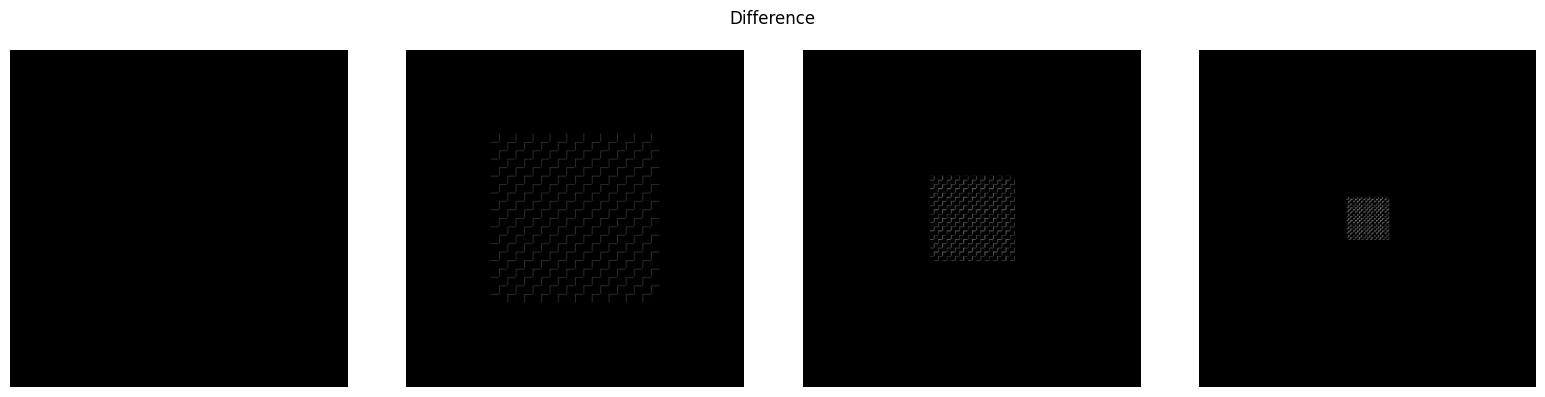

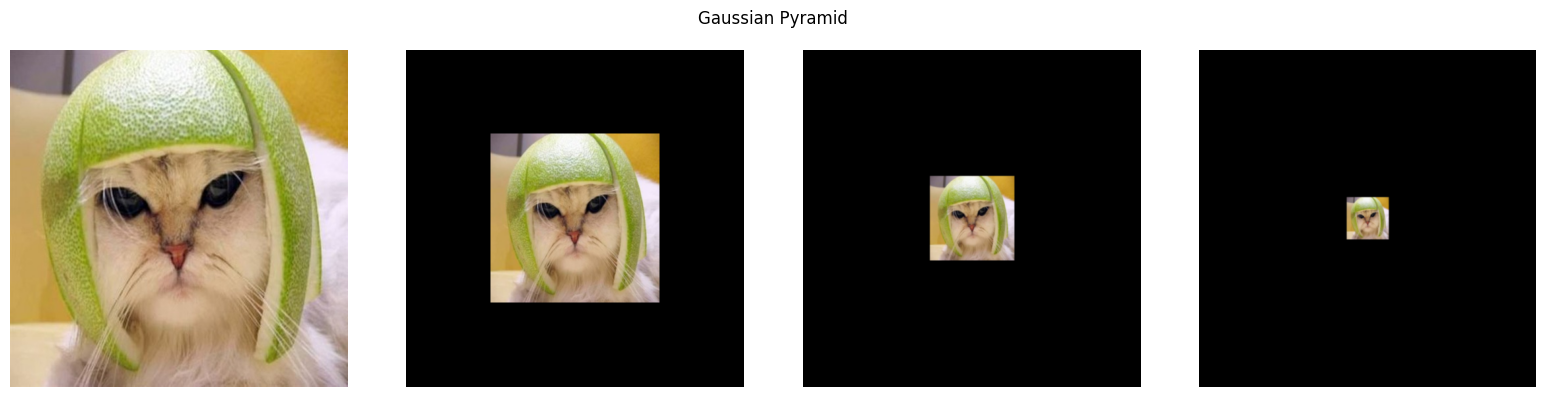

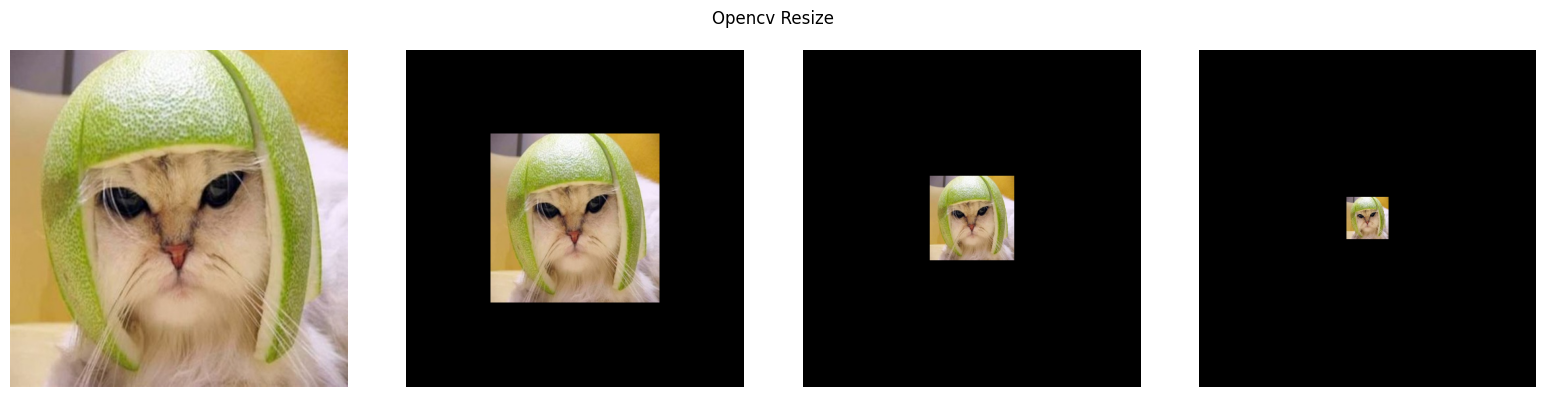

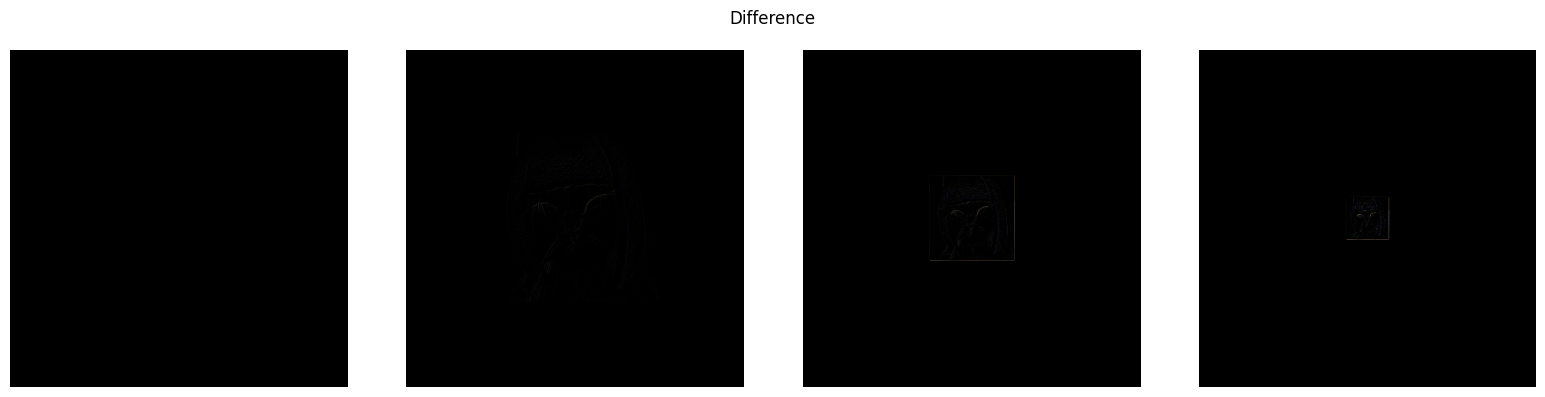

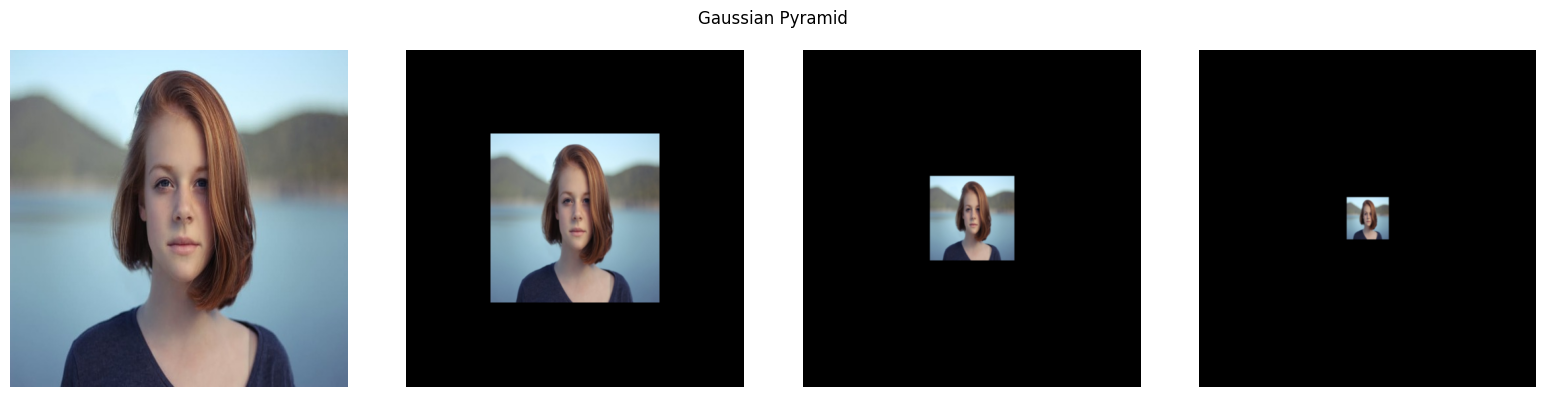

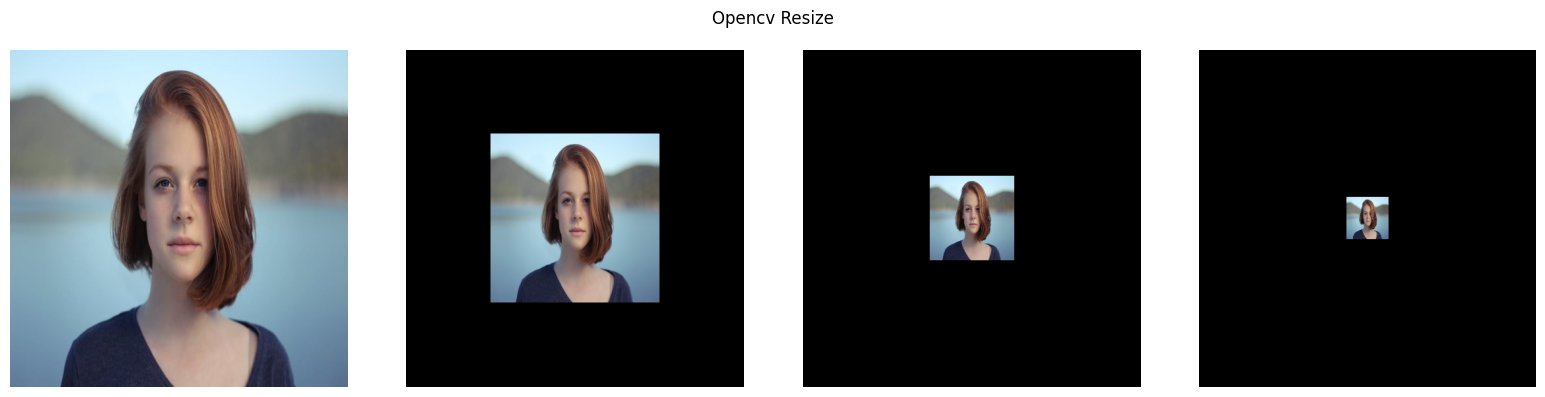

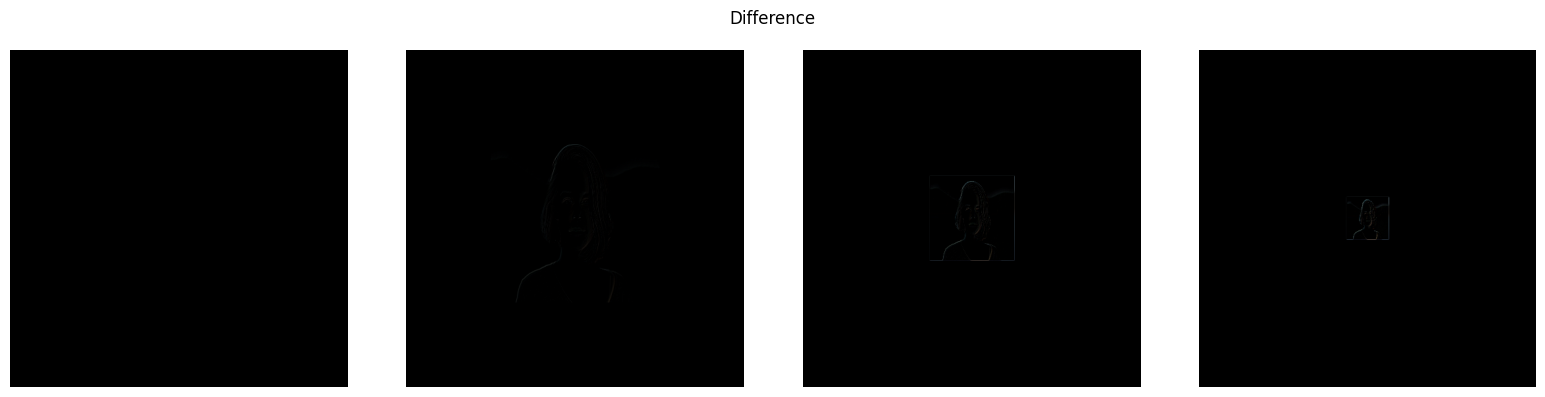

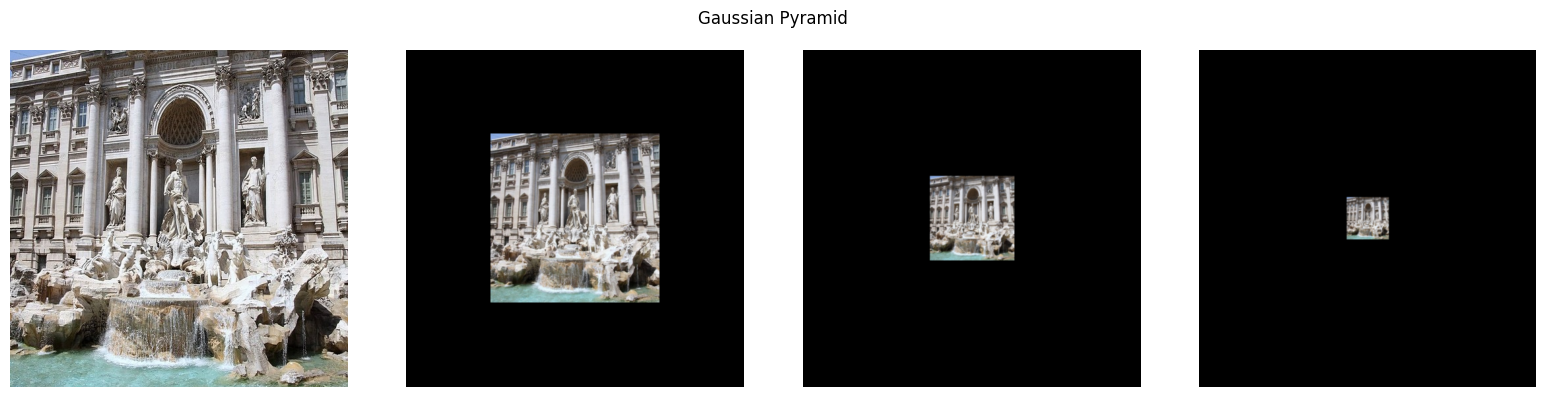

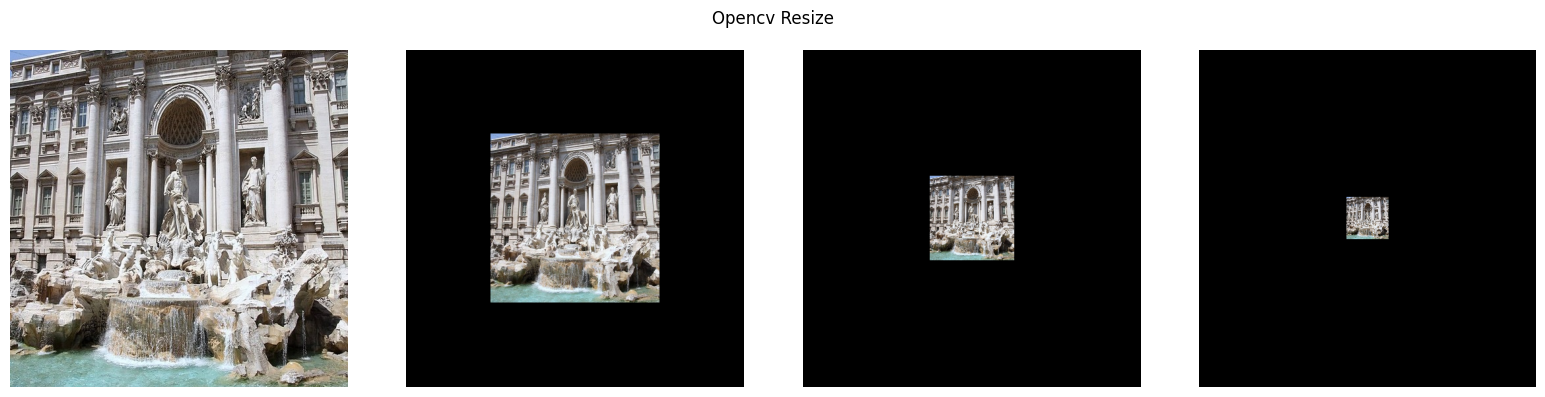

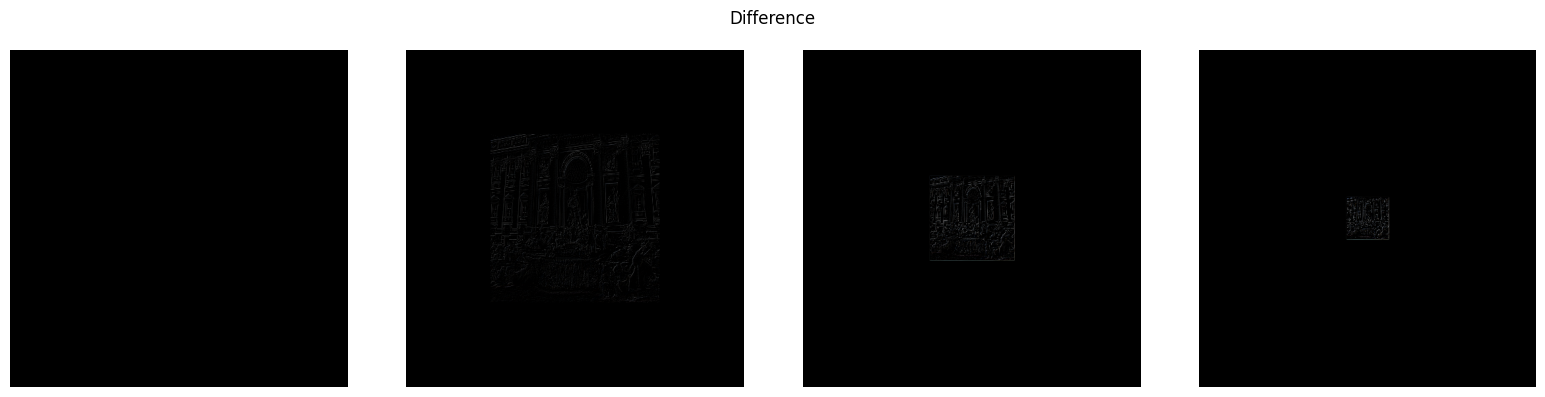

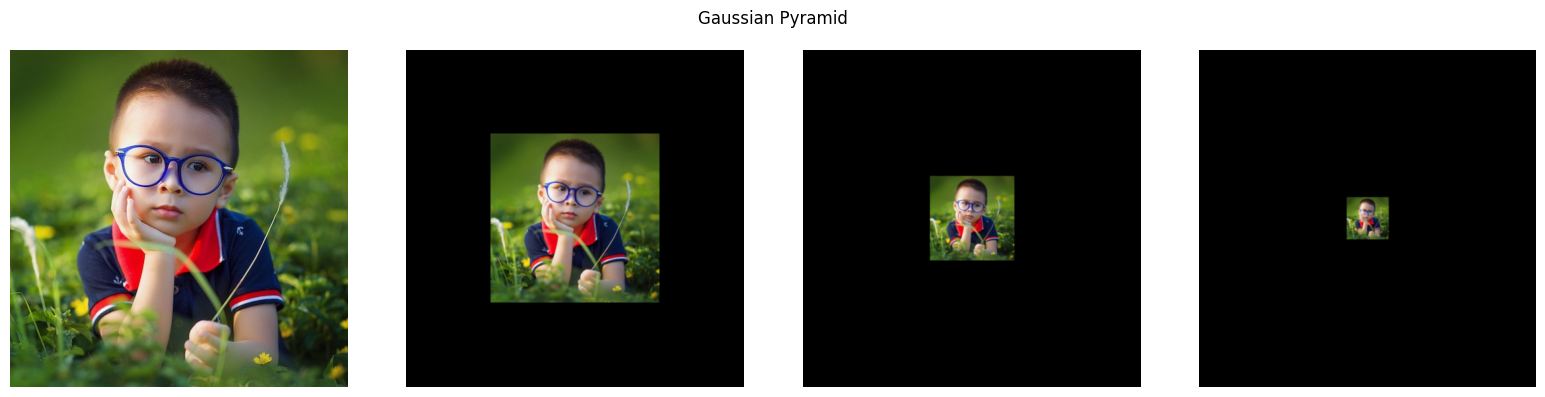

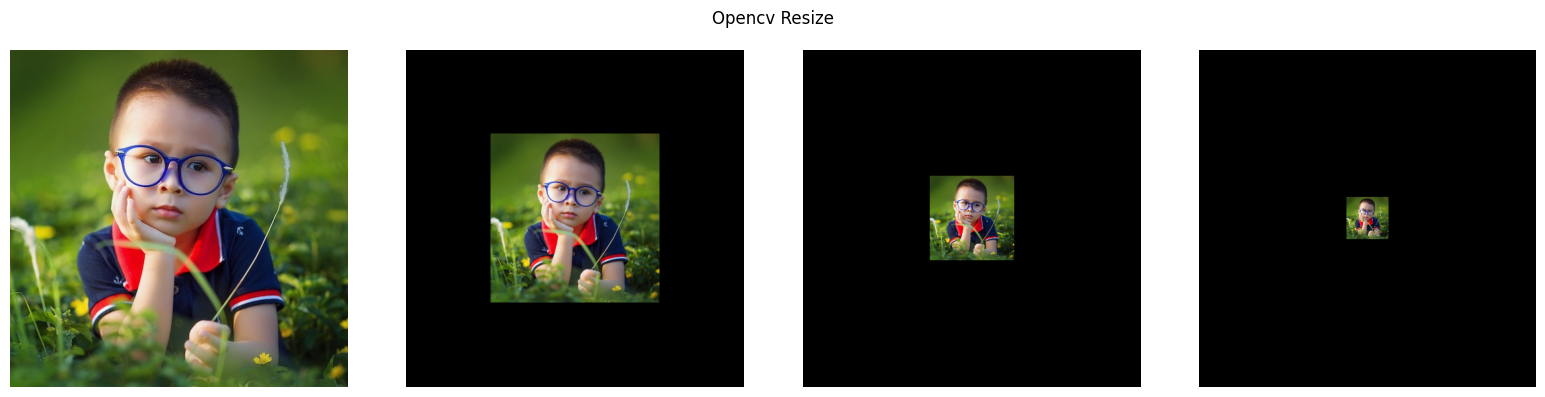

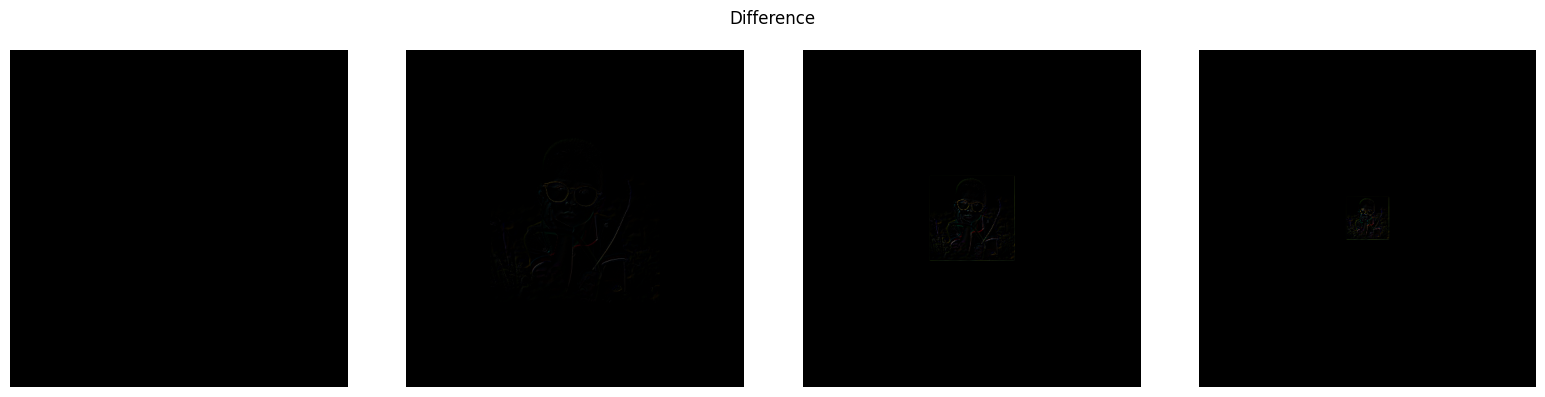

In [ ]:
for idx, image in enumerate(gt_images):

    # Generate pyramid of images for matching
    s_image_pyramids = gaussian_pyramid(image, levels=4)
    s_image_opecv_resize = opencv_resize(image, levels=4)

    diff = []
    for gauss_img, open_img in zip(s_image_pyramids, s_image_opecv_resize):
        diff.append(cv2.subtract(gauss_img, open_img))
    diff = np.array(diff)

    show_image_grid(s_image_pyramids, 1, 4, 'Gaussian Pyramid', figsize=16)
    show_image_grid(s_image_opecv_resize, 1, 4, 'Opencv Resize', figsize=16)
    show_image_grid(diff, 1, 4, 'Difference', figsize=16)

Gaussian Pyramid: Applies Gaussian blur before downsampling to reduce aliasing and preserve features, resulting in smoother images with better detail preservation. However, the blurring step makes it slower.

OpenCV Resize: Uses built-in functions for fast image resizing, producing decent quality images but potentially losing details. It is faster due to optimized algorithms.


### Q2 [4 Marks]

You have to implement image blending technique using Laplacian Pyramids from scratch.

You can use following functions from opencv/scipy:

* convolution
* cv2.subtract
* cv2.add
* cv2.resize
* padding

You can follow this article for more explanation:

1. [Image Blending Using Laplacian Pyramids](https://becominghuman.ai/image-blending-using-laplacian-pyramids-2f8e9982077f)

In [ ]:
def upsample(img, target_size):
    # Increase the image size using linear interpolation
    resized_img = cv2.resize(img, (target_size[1], target_size[0]), interpolation=cv2.INTER_LINEAR)
    return resized_img

def downsample(img):
    # Reduce the image size by half through pixel subsampling
    return img[::2, ::2]

def generate_blend_mask(img):
    # Create a left-to-right gradient mask for blending
    rows, cols, _ = img.shape
    blend_mask = np.zeros((rows, cols), dtype=np.float32)

    transition_zone = cols // 50 # Transition width in the middle
    for i in range(cols):
        if i < (cols // 2 - transition_zone // 2):
            blend_mask[:, i] = 1.0  # Fully use the first image (left)
        elif i > (cols // 2 + transition_zone // 2):
            blend_mask[:, i] = 0.0  # Fully use the second image (right)
        else:
            # Gradually transition between the two images
            blend_mask[:, i] = 1 - (i - (cols // 2 - transition_zone // 2)) / transition_zone

    return blend_mask

def build_laplacian_pyramid(img, num_levels):
    gauss_pyramid = gaussian_pyramid(img, num_levels)
    laplacian_pyramid = []

    # Subtract upsampled images from the current Gaussian level to build Laplacian pyramid
    for idx in range(len(gauss_pyramid) - 1):
        next_level = gauss_pyramid[idx + 1]
        upscaled_img = upsample(next_level, (gauss_pyramid[idx].shape[0], gauss_pyramid[idx].shape[1]))
        laplacian_level = cv2.subtract(gauss_pyramid[idx], upscaled_img)
        laplacian_pyramid.append(laplacian_level)

    laplacian_pyramid.append(gauss_pyramid[-1])  # Keep the smallest Gaussian level
    return laplacian_pyramid

def combine_laplacian_pyramids(pyramid_a, pyramid_b, mask_pyramid):
    combined_pyramid = []

    for img_a, img_b, mask in zip(pyramid_a, pyramid_b, mask_pyramid):
        mask = mask.astype(np.float32)
        img_a = img_a.astype(np.float32)
        img_b = img_b.astype(np.float32)

        # Blend two Laplacian pyramids at each level using the mask
        blended_level = cv2.add(cv2.multiply(img_a, mask), cv2.multiply(img_b, 1 - mask))
        combined_pyramid.append(blended_level)

    return combined_pyramid

def reconstruct_from_pyramid(laplacian_pyramid):
    # Reconstruct the original image from its Laplacian pyramid
    reconstructed_img = laplacian_pyramid[-1]

    # Upsample and add each Laplacian level to reconstruct the image
    for idx in range(len(laplacian_pyramid) - 2, -1, -1):
        upscaled_img = upsample(reconstructed_img, (laplacian_pyramid[idx].shape[0], laplacian_pyramid[idx].shape[1]))
        reconstructed_img = cv2.add(upscaled_img, laplacian_pyramid[idx])

    return reconstructed_img

def gaussian_pyramid(img, num_levels): # gaussian pyramid without padding
    gauss_pyramid = [img]

    for _ in range(num_levels - 1):
        # Apply Gaussian blur and downsample the image
        blurred_img = cv2.GaussianBlur(img, (5, 5), 0)
        img = downsample(blurred_img)
        gauss_pyramid.append(img)

    return gauss_pyramid

def laplacian_pyramid_blend_images(image_a, image_b):
    blended_image = None

    # Define the number of levels for the pyramid
    num_levels = 2 # less levels - more clarity

    # Generate the blend mask and expand it to three channels for RGB images
    blend_mask = generate_blend_mask(image_a)
    blend_mask = np.repeat(blend_mask[:, :, np.newaxis], 3, axis=2)

    # Build Laplacian pyramids for both images
    laplacian_a = build_laplacian_pyramid(image_a, num_levels)
    laplacian_b = build_laplacian_pyramid(image_b, num_levels)

    # Create a Gaussian pyramid for the blend mask
    mask_pyramid = gaussian_pyramid(blend_mask, num_levels)

    # Combine the two Laplacian pyramids using the mask
    blended_pyramid = combine_laplacian_pyramids(laplacian_a, laplacian_b, mask_pyramid)

    # Reconstruct the final blended image from the combined pyramid
    blended_image = reconstruct_from_pyramid(blended_pyramid)
    blended_image = np.clip(blended_image, 0, 255).astype(np.uint8)  # Ensure pixel values are within valid range

    # If blending fails, return the first image by default
    if blended_image is None:
        return image_a

    return blended_image


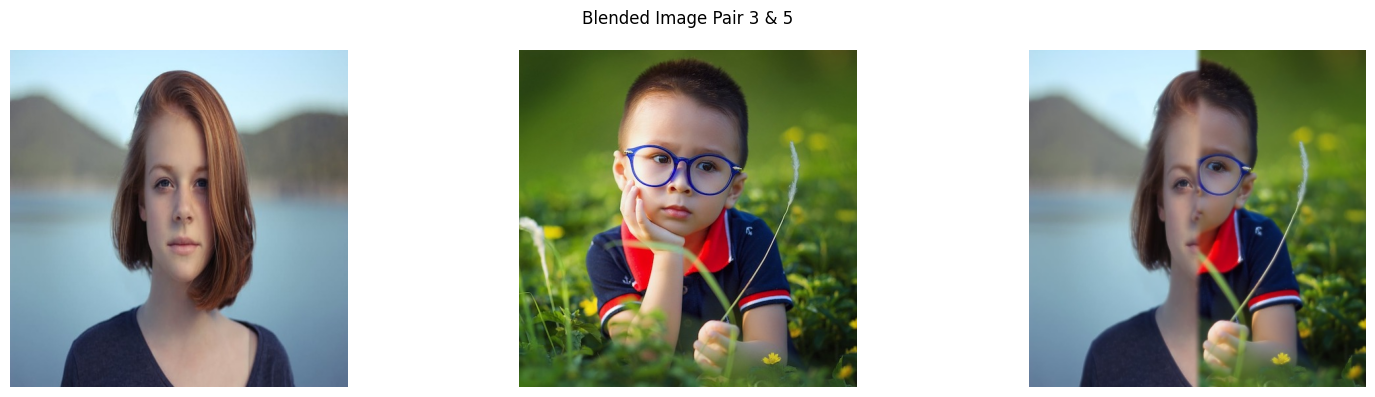

In [ ]:
blended_image = laplacian_pyramid_blend_images(gt_images[3], gt_images[5])
collage = np.array([gt_images[3], gt_images[5], blended_image])
show_image_grid(collage, 1, 3, 'Blended Image Pair 3 & 5', figsize=16)

### Q3 [4 Marks]

Implement Harris and Hessian Corner Detector algorithm from scratch.

You can use following functions from opencv/scipy:

* convolution
* cv2.subtract
* cv2.add
* cv2.resize
* padding

You can follow this article for more explanation:

1. [Harris and Hessian Corner Detector](https://medium.com/jun94-devpblog/cv-10-local-feature-descriptors-harris-and-hessian-corner-detector-7d524888abfd)

In [ ]:
from scipy.ndimage import convolve

def detect_harris_corner(image):
    corner_image  = None
    # Smooth the input image using Gaussian blur
    gaussian_sigma = 1
    gaussian_kernel_size = 3
    blurred_image = cv2.GaussianBlur(image,(gaussian_kernel_size, gaussian_kernel_size), gaussian_sigma)

    # Convert the blurred image to grayscale
    gray_image = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2GRAY)

    # Compute gradients using Sobel filters
    sobel_kernel_x = np.array([[-1, 0, 1],
                                [-2, 0, 2],
                                [-1, 0, 1]], dtype=np.float32)

    sobel_kernel_y = np.array([[-1, -2, -1],
                                [0, 0, 0],
                                [1, 2, 1]], dtype=np.float32)

    gradient_x = convolve(gray_image.astype(np.float32), sobel_kernel_x)  # Gradient along x-axis
    gradient_y = convolve(gray_image.astype(np.float32), sobel_kernel_y)  # Gradient along y-axis

    # Calculate squared gradients and the product of gradients
    gradient_x_squared = gradient_x ** 2
    gradient_y_squared = gradient_y ** 2
    gradient_xy_product = gradient_x * gradient_y

    # Apply Gaussian blur to the computed gradient images
    smoothed_x_squared = cv2.GaussianBlur(gradient_x_squared,
                                           (gaussian_kernel_size, gaussian_kernel_size),
                                           gaussian_sigma)

    smoothed_y_squared = cv2.GaussianBlur(gradient_y_squared,
                                           (gaussian_kernel_size, gaussian_kernel_size),
                                           gaussian_sigma)

    smoothed_xy_product = cv2.GaussianBlur(gradient_xy_product,
                                            (gaussian_kernel_size, gaussian_kernel_size),
                                            gaussian_sigma)

    # Compute the Harris response R for each pixel
    height, width = gray_image.shape
    harris_response = np.zeros((height, width))
    sensitivity_factor = 0.06  # Sensitivity factor for corner detection (K)

    for i in range(height):
        for j in range(width):
            determinant_M = (smoothed_x_squared[i, j] * smoothed_y_squared[i, j] - smoothed_xy_product[i, j] ** 2)
            trace_M = smoothed_x_squared[i, j] + smoothed_y_squared[i, j]
            harris_response[i, j] = determinant_M - sensitivity_factor * (trace_M ** 2)

    # Threshold the Harris response to detect corners
    threshold_value = 0.03 * np.max(harris_response)  # Threshold to identify corners
    corner_image = np.zeros_like(harris_response, dtype=np.uint8)
    corner_image[harris_response > threshold_value] = 255  # Mark corners as white

    if corner_image is None:
        return image

    return corner_image  # Return the image with detected corners


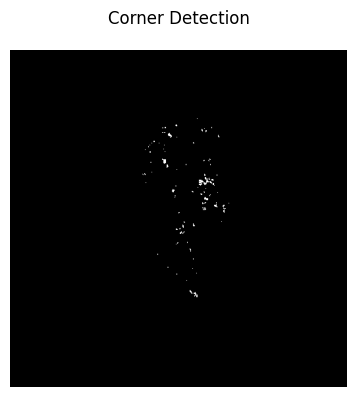

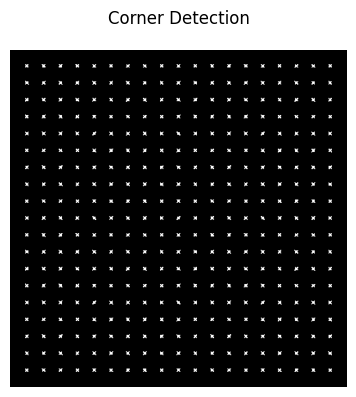

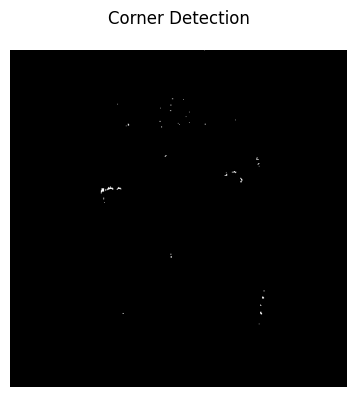

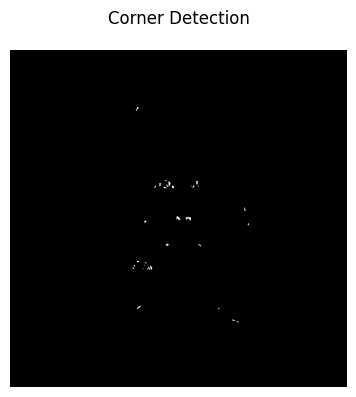

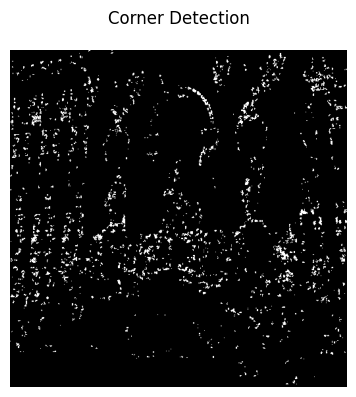

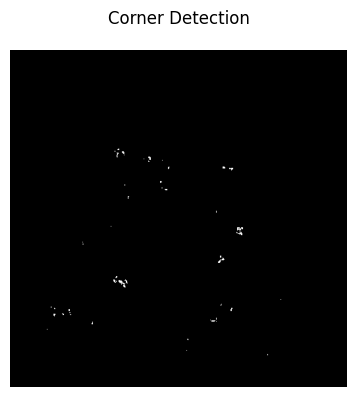

In [ ]:
for image in gt_images:
    corner_image = detect_harris_corner(image)
    show_image_grid(corner_image, 1, 1, 'Corner Detection', figsize=16)